# MIE1624 Final Exam Project

In [30]:
# import necessary libriaries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score,precision_score,f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read files
# load data frame
ce_df = pd.read_csv('Canadian_elections_2021.csv')
ce_df

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN
...,...,...,...
997,This is absolutely horrible in Canada. The for...,negative,others
998,@davidakin Trudeau imposes gun control policie...,negative,gun control
999,In Canada 🇨🇦 our election is being stolen by t...,negative,others
1000,"O'Toole amends platform on gun control, but qu...",negative,tell lies


In [3]:
# load data frame
sa_df = pd.read_csv('sentiment_analysis.csv')
sa_df

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


## 1. Data Clean

### Remove all emojis

In [4]:
import re
# remove emoji
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
ce_df.text = ce_df.text.apply(remove_emoji)
sa_df.text = sa_df.text.apply(remove_emoji)

### Remove all URLs

In [5]:
# remove URLs
def remove_URL(string):
    clean_string = re.sub(r"http\S+", "", string)
    return clean_string

ce_df.text = ce_df.text.apply(remove_URL)
sa_df.text = sa_df.text.apply(remove_URL)

### Remove all characters in the text are in lowercase

In [6]:
# make all chars in lower case
def lower_case(string):
    return string.lower()

ce_df.text = ce_df.text.apply(lower_case)
sa_df.text = sa_df.text.apply(lower_case)

### Remove all stop words

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
ce_df.text = ce_df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
sa_df.text = sa_df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Lemmatize: do things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

def extract(text):
    words_in_each_tweet = word_tokenize(text)
    final = [lemmatizer.lemmatize(word) for word in words_in_each_tweet]
    stemmed_string = ' '.join(final)
    return stemmed_string

ce_df.text = ce_df.text.apply(extract)
sa_df.text = sa_df.text.apply(extract)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Remove all punctuations

In [9]:
# remove punctuations
def remove_punctuation(text):
    clean_string = re.sub(r'[^a-zA-Z]', ' ', text)
    return clean_string

ce_df.text = ce_df.text.apply(remove_punctuation)
sa_df.text = sa_df.text.apply(remove_punctuation)

In [10]:
ce_df['text'].isnull().sum()

0

## 2. Exploratory Analysis

### 2.1 
Design a procedure that determines the political party (Liberal, Conservative, New Democratic Party (NDP), The People's Party of Canada (PPC)) of a given tweet and apply this procedure to all the tweets in the Canadian Elections dataset. 

In [110]:
# each party's keywords
liberal = ['liber','lib','liberal', 'liberals','justin', 'trudeau', 'justintrudeau', 'timlouis', 'chooseforward', 'chooseforwardwithtrudeau', 'teamtrudeau', 'votingliberal']
conservative = ['conserv','con','otoole', 'erin', 'erinotoole', 'conservative', 'conservatives', 'cpc']
NDP = ['jagmeet', 'singh', 'thejagmeetsingh', 'uprisingh', 'ndp']
PPC = ['bernier', 'maximebernier', 'maximebernier', 'ppc']

In [111]:
# define a function to find matched party name for each tweets
def party_id(text):
    a = []
    
    for word in liberal:   
        if word in text:
            a.append('Liberal')
        
    for word in conservative:
        if word in text:
            a.append('Conservative')
           
    for word in NDP:
        if word in text:
            a.append('NDP')
            
    for word in PPC:
        if word in text:
            a.append('PPC')
            
    # if tweet has more than one party, choose the most common one
    if len(a) > 1:
        most_common = max(set(a), key=a.count)
        a = []
        a.append(most_common)
    # if no match party name, assign "Other"
    elif len(a) == 0:
        a.append('Other')
        
    return a

In [114]:
# store values
party_list = []
liberal_list = []
conservative_list = []
ndp_list = []
ppc_list = []
other_list = []

# find matched party name for each tweets in canadian elections dataset
for i in range(len(ce_df)):   
    party_name = party_id(ce_df['text'][i])[0]
    party_list.append(party_name)
    if party_name == 'Liberal':
        liberal_list.append(ce_df['text'][i])
    elif party_name == 'Conservative':
        conservative_list.append(ce_df['text'][i])
    elif party_name == 'NDP':
        ndp_list.append(ce_df['text'][i])
    elif party_name == 'PPC':
        ppc_list.append(ce_df['text'][i])
    elif party_name == 'Other':
        other_list.append(ce_df['text'][i])

In [ ]:
# find matched party name for each tweets in sentiment analysis dataset
sa_party_list=[]
for i in range(len(sa_df)):   
    sa_party_name = party_id(sa_df['text'][i])[0]
    sa_party_list.append(sa_party_name)
sa_df_party=sa_df.copy()
sa_df_party['party']=sa_party_list

### 2.2 Visualization

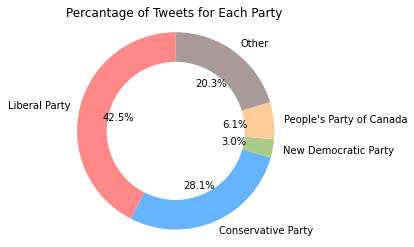

In [ ]:
# Canadian Election Dataset: Pie chart 
labels = 'Liberal Party', 'Conservative Party', 'New Democratic Party', "People's Party of Canada", 'Other'
sizes = [len(liberal_list)/ce_df.shape[0], len(conservative_list)/ce_df.shape[0], len(ndp_list)/ce_df.shape[0], 
         len(ppc_list)/ce_df.shape[0], len(other_list)/ce_df.shape[0]]
fig, ax = plt.subplots()
#colors
colors = ['#ff8888','#66b3ff','#aacc88','#ffcc99','#aa9999']
ax.pie(sizes, colors = colors,labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Percantage of Tweets for Each Party')
plt.show()

In [ ]:
print('Liberal Party has {:.1%}'.format(len(liberal_list)/ce_df.shape[0]),'tweets.')
print('Conservative Party has {:.1%}'.format(len(conservative_list)/ce_df.shape[0]),'tweets.')
print('New Democratic Party has {:.1%}'.format(len(ndp_list)/ce_df.shape[0]),'tweets.')
print("People's Party of Canada has {:.1%}".format(len(ppc_list)/ce_df.shape[0]),'tweets.')
print('Other has {:.1%}'.format(len(other_list)/ce_df.shape[0]),'tweets.')

Liberal Party has 42.5% tweets.
Conservative Party has 28.1% tweets.
New Democratic Party has 3.0% tweets.
People's Party of Canada has 6.1% tweets.
Other has 20.3% tweets.


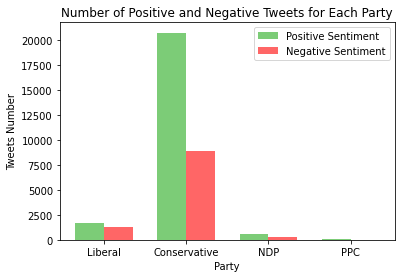

In [ ]:
# Sentiment_Analysis: Bar plot
a = sa_df_party[sa_df_party['label']==0]
negative_liberal = len(a[a['party']=='Liberal'])
negative_conservative = len(a[a['party']=='Conservative'])
negative_NDP = len(a[a['party']=='NDP'])
negative_PPC = len(a[a['party']=='PPC'])
negative_total = [negative_liberal,negative_conservative,negative_NDP,negative_PPC]

b = sa_df_party[sa_df_party['label']==1]
positive_liberal = len(b[b['party']=='Liberal'])
positive_conservative = len(b[b['party']=='Conservative'])
positive_NDP = len(b[b['party']=='NDP'])
positive_PPC = len(b[b['party']=='PPC'])
positive_total = [positive_liberal,positive_conservative,positive_NDP,positive_PPC]

index = np.arange(4)
width = 0.35
plt.bar(index, positive_total, width, color='#7CCC77', label='Positive Sentiment')
plt.bar(index+width, negative_total, width, color='#ff6666', label='Negative Sentiment')

plt.xlabel('Party')
plt.ylabel('Tweets Number')
plt.title('Number of Positive and Negative Tweets for Each Party')
plt.xticks(index+width/2,('Liberal', 'Conservative', 'NDP', 'PPC'))
plt.legend()
plt.show()

## 3. Sentiment Classification - Model Implementation and Tuning

### a. Machine learning models: 

Train seven classification algorithms on the training data from generic tweets: logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest, and XGBoost, where each tweet is considered a single observation/example, and the target variable is the sentiment value, which is either positive or negative.

In [28]:
# Split the generic tweets randomly into training data (80%) and test data (20%).
columns = ['text', 'label']
tw_train, tw_test = train_test_split(sa_df[columns].values, test_size=0.2, random_state=42)

np.random.shuffle(tw_train)
tw_train_X, tw_train_y = tw_train[:,[0]], tw_train[:, [1]]
tw_train_X, tw_train_y = tw_train_X.flatten(), tw_train_y.flatten().astype('int')
#print(tw_train_X.shape,tw_train_y.shape)

tw_test_X, tw_test_y = tw_test[:,[0]], tw_test[:, [1]]
tw_test_X, tw_test_y = tw_test_X.flatten(), tw_test_y.flatten().astype('int')
#print(tw_test_X.shape,tw_test_y.shape)

In [34]:
# perpare data using TF-IDF
v_tf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=5000)
v_tf.fit(tw_train_X)
train_X_tf = v_tf.transform(tw_train_X)
test_X_tf = v_tf.transform(tw_test_X)

**logistic regression**

In [35]:
log_tf = LogisticRegression()
log_tf.fit(train_X_tf, tw_train_y)
log_pred_tf = log_tf.predict(test_X_tf)
log_acc_tf = accuracy_score(tw_test_y, log_pred_tf)
print('Accuracy for logistic regression by using TF-IDF:', log_acc_tf)

Accuracy for logistic regression by using TF-IDF: 0.9689677413493946


**k-NN**

In [ ]:
knn_tf = KNeighborsClassifier()
knn_tf.fit(train_X_tf, tw_train_y)
knn_pred_tf = knn_tf.predict(test_X_tf)
knn_acc_tf = accuracy_score(tw_test_y, knn_pred_tf)
print('Accuracy for k-NN by using TF-IDF:', knn_acc_tf)

The accuracy for k-NN by using TF-IDF is 0.8801587950471934


**Naive Bayes**

In [ ]:
nb_tf = MultinomialNB()
nb_tf.fit(train_X_tf, tw_train_y)
nb_pred_tf = nb_tf.predict(test_X_tf)
nb_acc_tf = accuracy_score(tw_test_y, nb_pred_tf)
print('Accuracy for Naives Bayes by using TF-IDF:', nb_acc_tf)

Accuracy for Naives Bayes by using TF-IDF: 0.9316309196122785


**SVM**

In [ ]:
svm_tf = LinearSVC()
svm_tf.fit(train_X_tf, tw_train_y)
svm_pred_tf = svm_tf.predict(test_X_tf)
svm_acc_tf = accuracy_score(tw_test_y, svm_pred_tf)
print('Accuracy for SVM by using TF-IDF:', svm_acc_tf)

Accuracy for SVM by using TF-IDF: 0.9680502184794557


**Decision Trees**

In [ ]:
dt_tf = DecisionTreeClassifier()
dt_tf.fit(train_X_tf, tw_train_y)
dt_pred_tf = dt_tf.predict(test_X_tf)
dt_acc_tf = accuracy_score(tw_test_y, dt_pred_tf)
print('Accuracy for decision trees by using TF-IDF:', dt_acc_tf)

Accuracy for decision trees by using TF-IDF: 0.9412785363239128


**Random Forest**

In [ ]:
rf_tf = RandomForestClassifier()
rf_tf.fit(train_X_tf, tw_train_y)
rf_pred_tf = rf_tf.predict(test_X_tf)
rf_acc_tf = accuracy_score(tw_test_y, rf_pred_tf)
print('Accuracy for random forest by using TF-IDF:', rf_acc_tf)

Accuracy for random forest by using TF-IDF: 0.959483643565076


**XGBoost**

In [ ]:
xgb_tf = xgb.XGBClassifier()
xgb_tf.fit(train_X_tf, tw_train_y)
xgb_pred_tf = xgb_tf.predict(test_X_tf)
xgb_acc_tf = accuracy_score(tw_test_y, xgb_pred_tf)
print('Accuracy for XGBoost by using TF-IDF:', xgb_acc_tf)

Accuracy for XGBoost by using TF-IDF: 0.8553039180951861


Logistic regression model has the highest accuracy score around 96.9% by using TF-IDF.

### b. Deep learning model: 

In [12]:
# Split the generic tweets into training data (60%), validation data (20%) and test data (20%).
columns = ['text', 'label']
twd_train, twd_test = train_test_split(sa_df[columns].values, test_size=0.4, random_state=42)
twd_test, twd_val = train_test_split(twd_test, test_size = 0.5, train_size =0.5, random_state=42)
#print(twd_train.shape)
#print(twd_test.shape)
#print(twd_val.shape)

np.random.shuffle(twd_train)
twd_train_X, twd_train_y = twd_train[:,[0]], twd_train[:, [1]]
twd_train_X, twd_train_y = twd_train_X.flatten(), twd_train_y.flatten().astype('int')
#print(twd_train_X.shape,twd_train_y.shape)

twd_test_X, twd_test_y = twd_test[:,[0]], twd_test[:, [1]]
twd_test_X, twd_test_y = twd_test_X.flatten(), twd_test_y.flatten().astype('int')
#print(twd_test_X.shape,twd_test_y.shape)

twd_val_X, twd_val_y = twd_val[:,[0]], twd_val[:, [1]]
twd_val_X, twd_val_y = twd_val_X.flatten(), twd_val_y.flatten().astype('int')
#print(twd_val_X.shape,twd_val_y.shape)

In [24]:
# Prepare the data using Bag of Words
v_wf = CountVectorizer(max_features=5000)
v_wf.fit(twd_train_X)
bw_train_X = v_wf.transform(twd_train_X)
bw_test_X = v_wf.transform(twd_test_X)
bw_val_X = v_wf.transform(twd_val_X)

In [ ]:
!pip install keras
!pip install tensorflow --upgrade
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import numpy as np
import tensorflow as tf

In [26]:
# define function to convert matrix to tensor
def convert(matrix):
    coo = matrix.tocoo()
    index = np.mat([coo.row, coo.col]).transpose() 
    return tf.SparseTensor(index, coo.data, coo.shape)
bw_train_X = convert(bw_train_X)

In [27]:
# Define a deep learning model - artificial neural nets
np.random.seed(9)

model = Sequential()
# Hidden Layer (Layer 1)
model.add(Dense(units=4, activation='sigmoid', input_dim=5000))
# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

print(model.summary())
print('')

sgd = tf.keras.optimizers.SGD(lr=1)
model.compile(loss='mean_squared_error', optimizer=sgd,metrics=['accuracy'])

trainy=np.array(twd_train_y)
model.fit(bw_train_X, trainy, epochs=10, verbose=1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 20004     
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 20,009
Trainable params: 20,009
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/10
10320/10320 [==============================] - 22s 2ms/step - loss: 0.0440 - accuracy: 0.9453
Epoch 2/10
10320/10320 [==============================] - 24s 2ms/step - loss: 0.0261 - accuracy: 0.9668
Epoch 3/10
10320/10320 [==============================] - 20s 2ms/step - loss: 0.0246 - accuracy: 0.9686
Epoch 4/10
10320/10320 [==============================] - 21s 2ms/step - loss: 0.0238 - accuracy: 0.9698
Epoch 5/10
10320/103

In this deep learning model, it has the highest accuracy at epoch 10, which is 97.31%.

In [36]:
def deep_learning(lr,epochs):
  np.random.seed(9)
  model = Sequential()
  # Hidden Layer (Layer 1)
  model.add(Dense(units=4, activation='sigmoid', input_dim=5000))
  # Output Layer
  model.add(Dense(units=1, activation='sigmoid'))

  sgd = tf.keras.optimizers.SGD(lr=lr)
  model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

  trainy=np.array(twd_train_y)
  a=model.fit(bw_train_X, trainy, epochs, verbose=1)
  return a

Changing two hyperparameters: learning rate and epoch size.

In [47]:
# learning rate
lr_list = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]  ###1e-3 * (10 ** (np.arange(100) / 30))
# epoch count
epoch_list = [1,5,10,15,20,25,30]

for i in range(len(lr_list)):
  for j in range(len(epoch_list)):
    deep_learning(lr_list[i],epoch_list[j])

11008/11008 [==============================] - 46s 4ms/step - loss: 0.2231 - accuracy: 0.6747


As epoch size getting larger, accuracy decrease. 
As learning rate get smaller, accuracy decrease. 
The deep learning model has the highest accuracy at epoch 10 with learning rate = 1, which is 97.31%.

In [ ]:
### Alternative: Changing optimizer and loss
def deeplearning(optimizer='adam',loss='mean_squared_error'):
  np.random.seed(9)
  model = Sequential()
  # Hidden Layer (Layer 1)
  model.add(Dense(units=4, activation='sigmoid', input_dim=5000))
  # Output Layer
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

# create model
model = KerasClassifier(build_fn=deeplearning, epochs=10, verbose=1)

# define the grid search hyper parameter options and dictionary
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
loss= ['mean_squared_error', 'mean_squared_logarithmic_error','mean_absolute_error','binary_crossentropy',
       'hinge','squared_hinge','categorical_crossentropy','sparse_categorical_crossentropy','kullback_leibler_divergence']
param_grid = dict(optimizer=optimizer,loss=loss)

#create the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
trainy=np.array(twd_train_y)
grid_result = grid.fit(bw_train_X, trainy)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### c. Evaluate the trained model with the best performance on the Canadian Elections data

Logistic model gives an accuracy score around 70% for its predictions to match the sentiment labelled in the Canadian elections data. Deep learning model has its highest accuracy at 89.72% in epoch 10, and lowest accuracy at 61.38% in epoch 1.

In [80]:
# data set
ce_X = ce_df['text']
ce_df['sentiment'] = ce_df.sentiment.replace({'negative': 0, 'positive': 1})
ce_y = ce_df['sentiment'].values
ce_X_tf = v_tf.transform(ce_X)
# logistic model
logistic_pred = log_tf.predict(ce_X_tf)
logistic_acc = accuracy_score(ce_y, logistic_pred)
print('Accuracy for logistic regression by using TF-IDF: ', round(logistic_acc,3))

Accuracy for logistic regression by using TF-IDF:  0.705


In [108]:
# Prepare the data using Bag of Words
ce_X_wf = v_wf.transform(ce_X)

# deep learning model
np.random.seed(9)
model = Sequential()
# Hidden Layer (Layer 1)
model.add(Dense(units=4, activation='sigmoid', input_dim=1890))
# Output Layer
model.add(Dense(units=1, activation='sigmoid'))
sgd = tf.keras.optimizers.SGD(lr=1)
model.compile(loss='mean_squared_error', optimizer=sgd,metrics=['accuracy'])
ce_X_sparse = convert(ce_X_wf)
ce_y_array = np.array(ce_y)
model.fit(ce_X_sparse, ce_y_array, epochs=10, verbose=1, shuffle = True)

Epoch 1/10
32/32 [==============================] - 1s 4ms/step - loss: 0.2341 - accuracy: 0.6138
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2228 - accuracy: 0.6178
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2069 - accuracy: 0.6577
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1892 - accuracy: 0.7525
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1714 - accuracy: 0.7814
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1545 - accuracy: 0.8214
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1391 - accuracy: 0.8533
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1238 - accuracy: 0.8743
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1117 - accuracy: 0.8852
Epoch 10/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1019 - accuracy: 0.8972


### d. Other evaluation metrics to evaluate model


Classification Metrics (precision, recall…) and Regression Metrics (MSE and so on).

Precision is a measure of how many of the positive predictions made are correct, while recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data. Both precision and recall are based on relevance.

MSE is defined as Mean or Average of the square of the difference between actual and estimated values. It is used to check how close estimates or forecasts are to actual values. Lower the MSE, the closer is forecast to actual.

In [126]:
from sklearn.metrics import recall_score,precision_score
print('Precision Score: ' + str(precision_score(ce_y, logistic_pred)))
print('Recall Score: ' + str(recall_score(ce_y, logistic_pred)))
print('MSE Score: ' + str(np.square(np.subtract(ce_y,logistic_pred)).mean()))

Precision Score: 0.8880778588807786
Recall Score: 0.5934959349593496
MSE Score: 0.2954091816367265


### e. Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 4 parties

NLP analytics based on tweets is useful for political parties during election campaigns. Although the predicted negative sentiment is higher than the actual negative sentiment while the predicted positive sentiment is lower than the actual positive sentiment, the overall trend predicted is the same as the real situation that Liberal party had the most number of both positive and negative tweets.

According to the graph, the Liberal Party is the most popular party on Twitter, with nearly half of the tweets about it, followed by the Conservative Party and the least number of tweets about the NDP. Sentiment analysis shows that the distribution of positive and negative sentiment is consistent for all political parties.

One way to improve the accuracy of the model is to increase the sample size.

In [117]:
# create a data frame for canadian election dataset with matched party name
ce_df_party=ce_df.copy()
ce_df_party['party']=party_list
ce_df_party['predict'] = logistic_pred

In [120]:
#Liberal Party
lib_pos = ce_df_party.loc[ce_df_party['sentiment'] == 1][ce_df_party['party'] == 'Liberal'].shape[0] #number of positive tweets
lib_neg = ce_df_party.loc[ce_df_party['sentiment'] == 0][ce_df_party['party'] == 'Liberal'].shape[0] #number of negative tweets
lib_pos_pred = ce_df_party.loc[ce_df_party['predict'] == 1][ce_df_party['party'] == 'Liberal'].shape[0] #number of positive tweets predicted
lib_neg_pred = ce_df_party.loc[ce_df_party['predict'] == 0][ce_df_party['party'] == 'Liberal'].shape[0] #number of negative tweets predicted

#Conservative Party
con_pos = ce_df_party.loc[ce_df_party['sentiment'] == 1][ce_df_party['party'] == 'Conservative'].shape[0]
con_neg = ce_df_party.loc[ce_df_party['sentiment'] == 0][ce_df_party['party'] == 'Conservative'].shape[0]
con_pos_pred = ce_df_party.loc[ce_df_party['predict'] == 1][ce_df_party['party'] == 'Conservative'].shape[0]
con_neg_pred = ce_df_party.loc[ce_df_party['predict'] == 0][ce_df_party['party'] == 'Conservative'].shape[0]

#NDP
ndp_pos = ce_df_party.loc[ce_df_party['sentiment'] == 1][ce_df_party['party'] == 'NDP'].shape[0]
ndp_neg = ce_df_party.loc[ce_df_party['sentiment'] == 0][ce_df_party['party'] == 'NDP'].shape[0]
ndp_pos_pred = ce_df_party.loc[ce_df_party['predict'] == 1][ce_df_party['party'] == 'NDP'].shape[0]
ndp_neg_pred = ce_df_party.loc[ce_df_party['predict'] == 0][ce_df_party['party'] == 'NDP'].shape[0]

#PPC
ppc_pos = ce_df_party.loc[ce_df_party['sentiment'] == 1][ce_df_party['party'] == 'PPC'].shape[0]
ppc_neg = ce_df_party.loc[ce_df_party['sentiment'] == 0][ce_df_party['party'] == 'PPC'].shape[0]
ppc_pos_pred = ce_df_party.loc[ce_df_party['predict'] == 1][ce_df_party['party'] == 'PPC'].shape[0]
ppc_neg_pred = ce_df_party.loc[ce_df_party['predict'] == 0][ce_df_party['party'] == 'PPC'].shape[0]

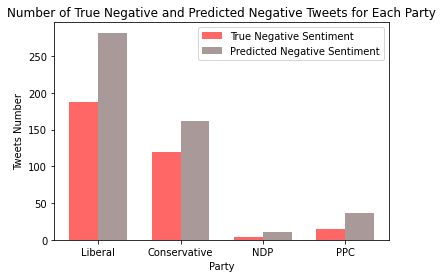

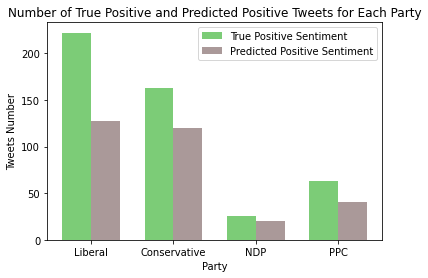

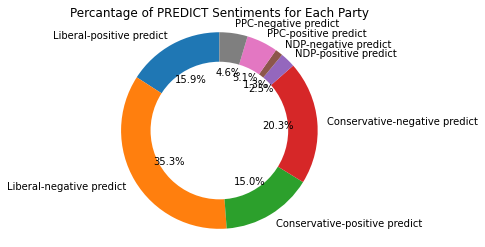

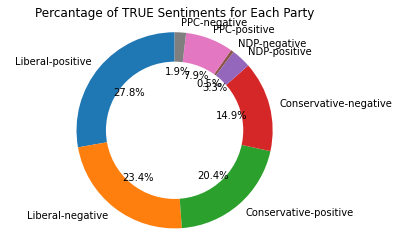

In [148]:
# Bar plot - Number of True Negative and Predicted Negative Tweets for Each Party
true_neg_total = [lib_neg, con_neg, ndp_neg, ppc_neg]
pred_neg_total = [lib_neg_pred, con_neg_pred, ndp_neg_pred, ppc_neg_pred]

index = np.arange(4)
width = 0.35
plt.bar(index, true_neg_total, width, color='#ff6666', label='True Negative Sentiment')
plt.bar(index+width, pred_neg_total, width, color='#aa9999', label='Predicted Negative Sentiment')
plt.xlabel('Party')
plt.ylabel('Tweets Number')
plt.title('Number of True Negative and Predicted Negative Tweets for Each Party')
plt.xticks(index+width/2,('Liberal', 'Conservative', 'NDP', 'PPC'))
plt.legend()
plt.show()

# Bar plot - Number of True Positive and Predicted Positive Tweets for Each Party
true_pos_total = [lib_pos, con_pos, ndp_pos, ppc_pos]
pred_pos_total = [lib_pos_pred, con_pos_pred, ndp_pos_pred, ppc_pos_pred]

plt.bar(index, true_pos_total, width, color='#7CCC77', label='True Positive Sentiment')
plt.bar(index+width, pred_pos_total, width, color='#aa9999', label='Predicted Positive Sentiment')
plt.xlabel('Party')
plt.ylabel('Tweets Number')
plt.title('Number of True Positive and Predicted Positive Tweets for Each Party')
plt.xticks(index+width/2,('Liberal', 'Conservative', 'NDP', 'PPC'))
plt.legend()
plt.show()

# Pie Chart - Percantage of Predict Sentiments for Each Party
labels = ['Liberal-positive predict', 'Liberal-negative predict', 
          'Conservative-positive predict', 'Conservative-negative predict', 
          'NDP-positive predict', 'NDP-negative predict', 
          "PPC-positive predict", "PPC-negative predict"]
sizes = [lib_pos_pred, lib_neg_pred, con_pos_pred, con_neg_pred, ndp_pos_pred, ndp_neg_pred, ppc_pos_pred, ppc_neg_pred]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Percantage of PREDICT Sentiments for Each Party')
#plt.legend()
plt.show()


# Pie Chart - Percantage of True Sentiments for Each Party
labels = ['Liberal-positive', 'Liberal-negative', 
          'Conservative-positive', 'Conservative-negative', 
          'NDP-positive', 'NDP-negative', 
          "PPC-positive", "PPC-negative"]
sizes = [lib_pos, lib_neg, con_pos, con_neg, ndp_pos, ndp_neg, ppc_pos, ppc_neg]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Percantage of TRUE Sentiments for Each Party')
#plt.legend()
plt.show()

## 4. Negative Reason Classification - Model implementation and tuning

a) Provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. \\
One possible reason is the data set is not normalized, and data is not perfectly balanced. Moreover, the distribution of each negative cause is different. Better performance can be achieved with more data.

b) Suggest one way you can improve the accuracy of your selected model. \\
Obtaining more data.

c) Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques. \\


In [164]:
negative_df = ce_df[ce_df['sentiment']==0]
negative_df = negative_df[negative_df['negative_reason'].notna()]
negative_reasons = negative_df['negative_reason'].unique()
print(negative_reasons)

['calling election early' 'covid ' 'others' 'scandal' 'tell lies'
 'gun control' 'economy' 'healthcare and marijuana' 'segregation'
 'women reproductive right and racism' 'climate problem']


In [162]:
#Encoding negative reasons
reasons_dict = { 
    'calling election early': 0,
    'covid ': 1,
    'others': 2,
    'scandal': 3, 
    'tell lies': 4,
    'gun control': 5,
    'economy': 6,
    'healthcare and marijuana': 7,
    'segregation': 8,
    'women reproductive right and racism': 9,
    'climate problem': 10}

negative_df['negative_reason'] = negative_df['negative_reason'].apply(lambda x:reasons_dict[x])
columns = ['text', 'negative_reason']

negative_train, negative_test = train_test_split(negative_df[columns].values, test_size=0.3, random_state=42)

negative_train_X, negative_train_y = negative_train[:,[0]].flatten(), negative_train[:,[1]].flatten().astype('int')
negative_test_X, negative_test_y = negative_test[:, [0]].flatten(), negative_test[:,[1]].flatten().astype('int')

In [100]:
# using TF-IDF
v_tf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=5000)
v_tf.fit(negative_train_X)
negative_train_X_tf = v_tf.transform(negative_train_X)
negative_test_X_tf = v_tf.transform(negative_test_X)
# Logistic model
n_log_tf = LogisticRegression()
n_log_tf.fit(negative_train_X_tf, negative_train_y)
n_log_pred_tf = n_log_tf.predict(negative_test_X_tf)
n_log_acc_tf = accuracy_score(negative_test_y, n_log_pred_tf)
print('Accuracy for logistic regression by using TF-IDF:', n_log_acc_tf)

Accuracy for logistic regression by using TF-IDF: 0.42735042735042733


In [102]:
# using Bag of Words
v_wf = CountVectorizer(max_features=5000)
v_wf.fit(negative_train_X)
bw_negative_train_X = v_wf.transform(negative_train_X)
bw_negative_test_X = v_wf.transform(negative_test_X)
# Logistic model
n_log_bw = LogisticRegression()
n_log_bw.fit(bw_negative_train_X, negative_train_y)
n_log_pred_bw = n_log_bw.predict(bw_negative_test_X)
n_log_acc_bw = accuracy_score(negative_test_y, n_log_pred_bw)
print('Accuracy for logistic regression by using Bag of Words:', n_log_acc_bw)

Accuracy for logistic regression by using Bag of Words: 0.452991452991453


In [156]:
def tune_log(train_X):
  score = 'accuracy'
  tuned_parameters = {'C': [1, 10, 100],'solver': ['sag', 'saga']}

  clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring=score, cv=3)
  clf.fit(train_X, negative_train_y)

  print("Best parameters set found on development set:")
  print(grid.best_params_)
  print("Grid scores on development set:")
  means = clf.cv_results_['mean_test_score']
  stds = clf.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, clf.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
tune_log(negative_train_X_tf)
tune_log(bw_negative_train_X)

Best parameters set found on development set:
{'C': 100, 'solver': 'sag'}
Grid scores on development set:
0.467 (+/-0.031) for {'C': 1, 'solver': 'sag'}
0.474 (+/-0.046) for {'C': 1, 'solver': 'saga'}
0.448 (+/-0.021) for {'C': 10, 'solver': 'sag'}
0.470 (+/-0.046) for {'C': 10, 'solver': 'saga'}
0.478 (+/-0.031) for {'C': 100, 'solver': 'sag'}
0.463 (+/-0.038) for {'C': 100, 'solver': 'saga'}
Best parameters set found on development set:
{'C': 100, 'solver': 'sag'}
Grid scores on development set:
0.467 (+/-0.018) for {'C': 1, 'solver': 'sag'}
0.467 (+/-0.018) for {'C': 1, 'solver': 'saga'}
0.448 (+/-0.021) for {'C': 10, 'solver': 'sag'}
0.463 (+/-0.021) for {'C': 10, 'solver': 'saga'}
0.448 (+/-0.028) for {'C': 100, 'solver': 'sag'}
0.452 (+/-0.021) for {'C': 100, 'solver': 'saga'}
